In [10]:
# Importar bibliotecas essenciais
import kagglehub
import pandas as pd
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# --- Carregamento do Dataset Combinado Diretamente do Kaggle Hub ---
wine_dataset_slug = "ruthgn/wine-quality-data-set-red-white-wine"
wine_file_name = "wine-quality-white-and-red.csv"

df_raw_combined_wine = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    wine_dataset_slug,
    wine_file_name
)

print("DataFrame combinado de Vinhos Tinto e Branco carregado do Kaggle Hub:")
print(df_raw_combined_wine.head())
print("-" * 50)

# --- Salvando para Parquet (Boa prática para reusabilidade e performance) ---
output_dir = "data/processed"
os.makedirs(output_dir, exist_ok=True)
parquet_path = os.path.join(output_dir, "wine-quality-combined.parquet")

df_raw_combined_wine.to_parquet(parquet_path, engine="pyarrow", index=False)
print(f"DataFrame salvo com sucesso em formato Parquet: {parquet_path}")

# --- Carrega o DataFrame a partir do arquivo Parquet processado ---
df_wine = pd.read_parquet(parquet_path)

# --- NOVIDADE: Traduzir a coluna 'type' para português ---
df_wine['type'] = df_wine['type'].replace({'red': 'tinto', 'white': 'branco'})

print("\n--- Primeiras 5 linhas do DataFrame principal (carregado do Parquet, tipo traduzido) ---")
print(df_wine.head()) # Verifique se 'type' agora mostra 'tinto'/'branco'

print("\n--- Informações gerais do DataFrame principal ---")
df_wine.info()

print("\n--- Verificando valores ausentes no DataFrame principal ---")
print(df_wine.isnull().sum())

C:\Users\albet\AppData\Local\Temp\ipykernel_23920\2074274119.py:14: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_raw_combined_wine = kagglehub.load_dataset(


DataFrame combinado de Vinhos Tinto e Branco carregado do Kaggle Hub:
    type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0      

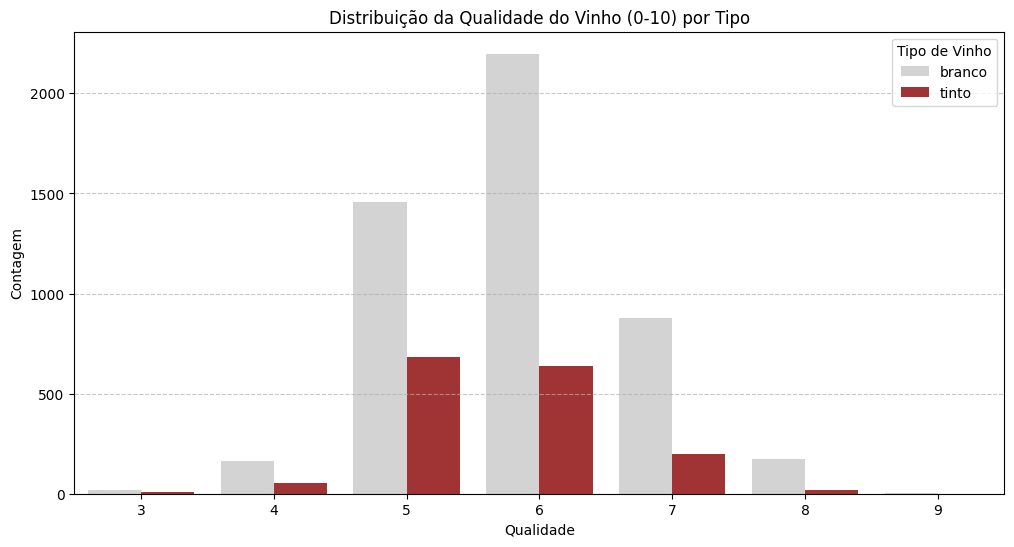


--- Contagem de cada nível de qualidade por tipo de vinho ---
type    quality
branco  3            20
        4           163
        5          1457
        6          2198
        7           880
        8           175
        9             5
tinto   3            10
        4            53
        5           681
        6           638
        7           199
        8            18
Name: count, dtype: int64

--- Contagem da nova variável 'good_quality' (Após corte >= 6) ---
good_quality
1    4113
0    2384
Name: count, dtype: int64


C:\Users\albet\AppData\Local\Temp\ipykernel_23920\3707985269.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='good_quality', data=df_wine, palette=custom_binary_palette_list)


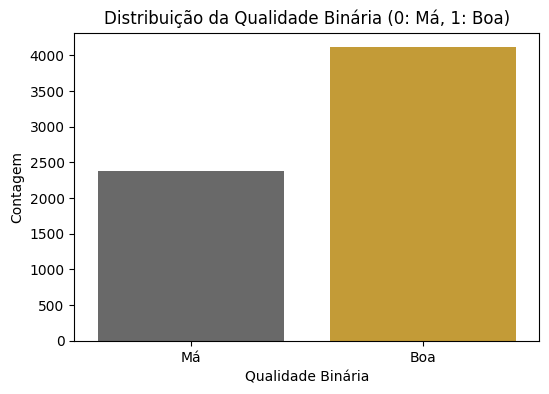

In [12]:
# --- 2.1 Distribuição da Qualidade Original (0-10) por Tipo de Vinho ---
plt.figure(figsize=(12, 6))
# A paleta agora deve usar as chaves em português
custom_type_palette = {'tinto': 'firebrick', 'branco': 'lightgrey'}
sns.countplot(x='quality', data=df_wine, hue='type', palette=custom_type_palette)
plt.title('Distribuição da Qualidade do Vinho (0-10) por Tipo')
plt.xlabel('Qualidade')
plt.ylabel('Contagem')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Tipo de Vinho')
plt.show()

print("\n--- Contagem de cada nível de qualidade por tipo de vinho ---")
print(df_wine.groupby('type')['quality'].value_counts().sort_index())

# --- 2.2 Criação da Variável Alvo Binária ('good_quality') para EDA ---
# Definir 'good_quality' para visualização do balanceamento
df_wine['good_quality'] = df_wine['quality'].apply(lambda x: 1 if x >= 6 else 0)

print("\n--- Contagem da nova variável 'good_quality' (Após corte >= 6) ---")
print(df_wine['good_quality'].value_counts())

# --- 2.3 Distribuição da Qualidade Binária (0: Má, 1: Boa) ---
plt.figure(figsize=(6, 4))
custom_binary_palette_list = ['dimgray', 'goldenrod']
sns.countplot(x='good_quality', data=df_wine, palette=custom_binary_palette_list)

plt.title('Distribuição da Qualidade Binária (0: Má, 1: Boa)')
plt.xlabel('Qualidade Binária')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Má', 'Boa'])
plt.show()

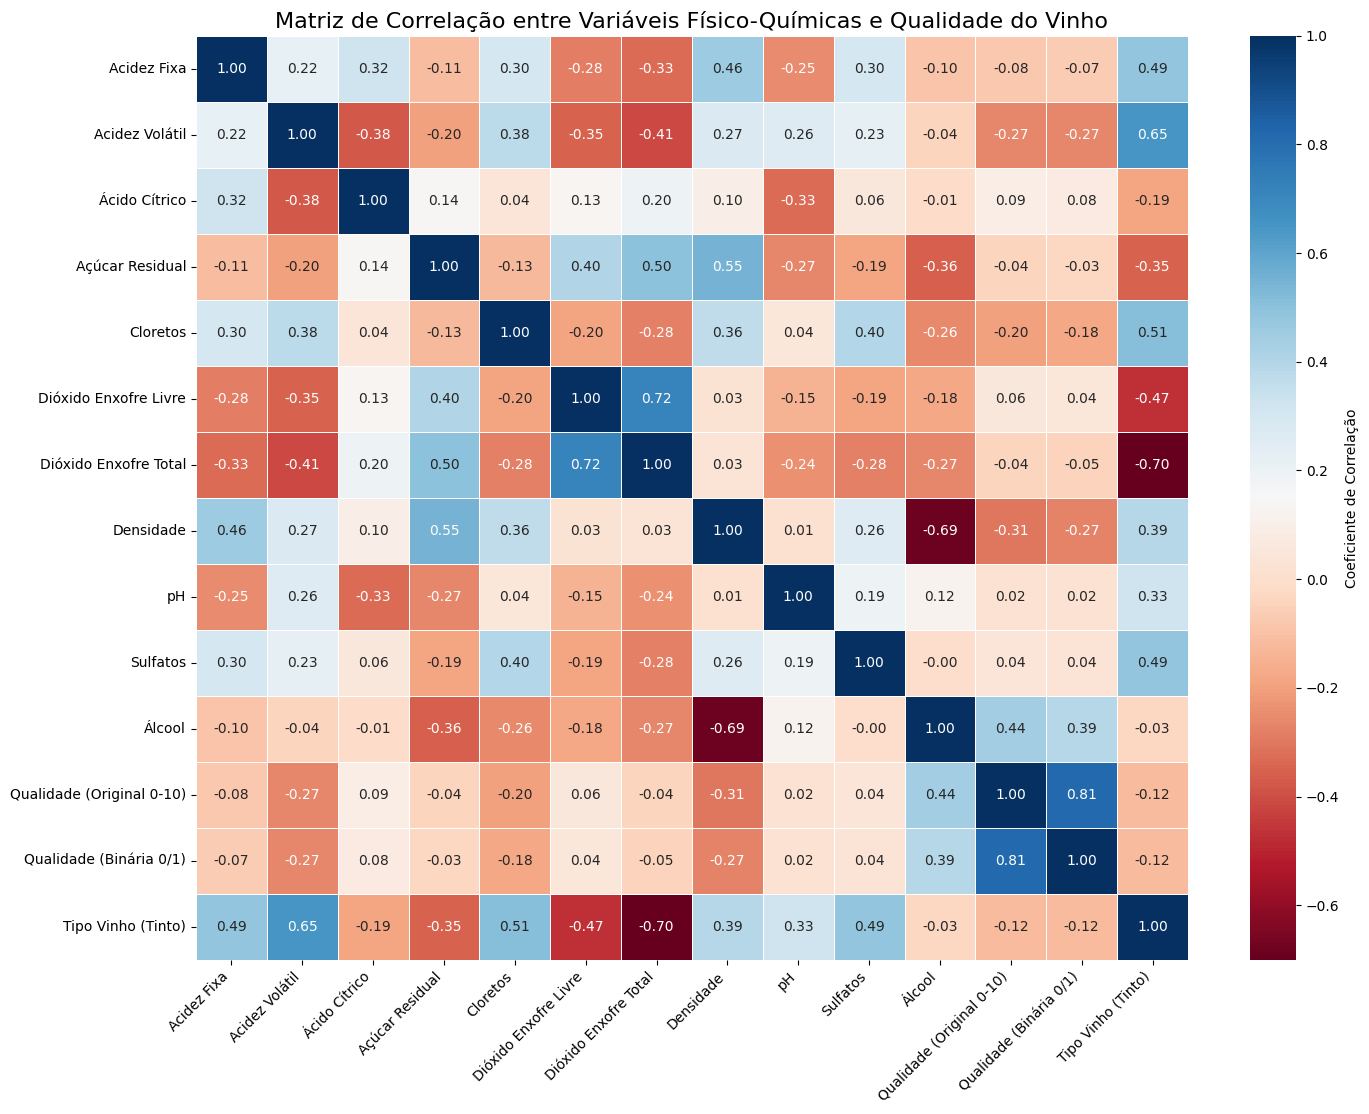


--- Correlações das variáveis (em português) com a Qualidade ---


KeyError: 'Qualidade (Binária)'

In [14]:
# --- 3.1 Matriz de Correlação entre Variáveis e Qualidade (Aprimorada) ---

# --- NOVIDADE: Mapeamento de nomes de colunas de Inglês para Português ---
column_translation = {
    'fixed acidity': 'Acidez Fixa',
    'volatile acidity': 'Acidez Volátil',
    'citric acid': 'Ácido Cítrico',
    'residual sugar': 'Açúcar Residual',
    'chlorides': 'Cloretos',
    'free sulfur dioxide': 'Dióxido Enxofre Livre',
    'total sulfur dioxide': 'Dióxido Enxofre Total',
    'density': 'Densidade',
    'pH': 'pH',
    'sulphates': 'Sulfatos',
    'alcohol': 'Álcool',
    'quality': 'Qualidade (Original 0-10)',      # NOVIDADE: Nome explícito para a qualidade original
    'good_quality': 'Qualidade (Binária 0/1)', # NOVIDADE: Nome explícito para a qualidade binária
}

# Criar uma cópia do DataFrame para aplicar as transformações de nome e OHE
df_corr_plot = df_wine.copy()

# Realizar One-Hot Encoding para a coluna 'type' na cópia do DataFrame
# Isso é necessário para que 'type_tinto' (ou 'type_branco') seja incluído na correlação numérica.
# df_wine['type'] já foi traduzido para 'tinto'/'branco' na Célula 1.
df_corr_plot = pd.get_dummies(df_corr_plot, columns=['type'], drop_first=True, dtype=int)

# --- NOVIDADE: Identificar dinamicamente e renomear a coluna do tipo de vinho OHE ---
# Se 'type_tinto' for a coluna gerada (porque 'branco' foi dropado por ordem alfabética)
if 'type_tinto' in df_corr_plot.columns:
    column_translation['type_tinto'] = 'Tipo Vinho (Tinto)'
# Se, por alguma razão, 'type_branco' for a coluna gerada, também podemos mapear
elif 'type_branco' in df_corr_plot.columns:
    column_translation['type_branco'] = 'Tipo Vinho (Branco)'

# Renomear as colunas do DataFrame usando o dicionário de tradução
df_corr_plot.rename(columns=column_translation, inplace=True)


# Calcular a matriz de correlação no DataFrame com colunas renomeadas
correlation_matrix_portuguese = df_corr_plot.corr()

# --- Aumentar o tamanho da figura e usar paleta de cores temática ---
plt.figure(figsize=(16, 12)) # Tamanho maior para os quadrados e números ficarem legíveis
sns.heatmap(correlation_matrix_portuguese, annot=True, cmap='RdBu', fmt=".2f", linewidths=.5, cbar_kws={'label': 'Coeficiente de Correlação'})
# 'RdBu' é uma paleta divergente clássica (Vermelho-Azul), com vermelho para correlação positiva
# e azul para correlação negativa.
plt.title('Matriz de Correlação entre Variáveis Físico-Químicas e Qualidade do Vinho', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10) # Rotação e tamanho da fonte para os rótulos do eixo X
plt.yticks(rotation=0, fontsize=10) # Tamanho da fonte para os rótulos do eixo Y
plt.show()

print("\n--- Correlações das variáveis (em português) com a Qualidade ---")
# Ordenar pela correlação com a 'Qualidade (Binária)' para ver as mais determinantes
print(correlation_matrix_portuguese['Qualidade (Binária)'].sort_values(ascending=False))


--- Box Plots das Features Mais Importantes (selecionadas da correlação) ---


C:\Users\albet\AppData\Local\Temp\ipykernel_23920\3948942278.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='good_quality', y=feature, data=df_wine, palette='coolwarm')
C:\Users\albet\AppData\Local\Temp\ipykernel_23920\3948942278.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='good_quality', y=feature, data=df_wine, palette='coolwarm')
C:\Users\albet\AppData\Local\Temp\ipykernel_23920\3948942278.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='good_quality', y=feature, data=df_wine, palette='coolwarm')
C:\Users\albet\A

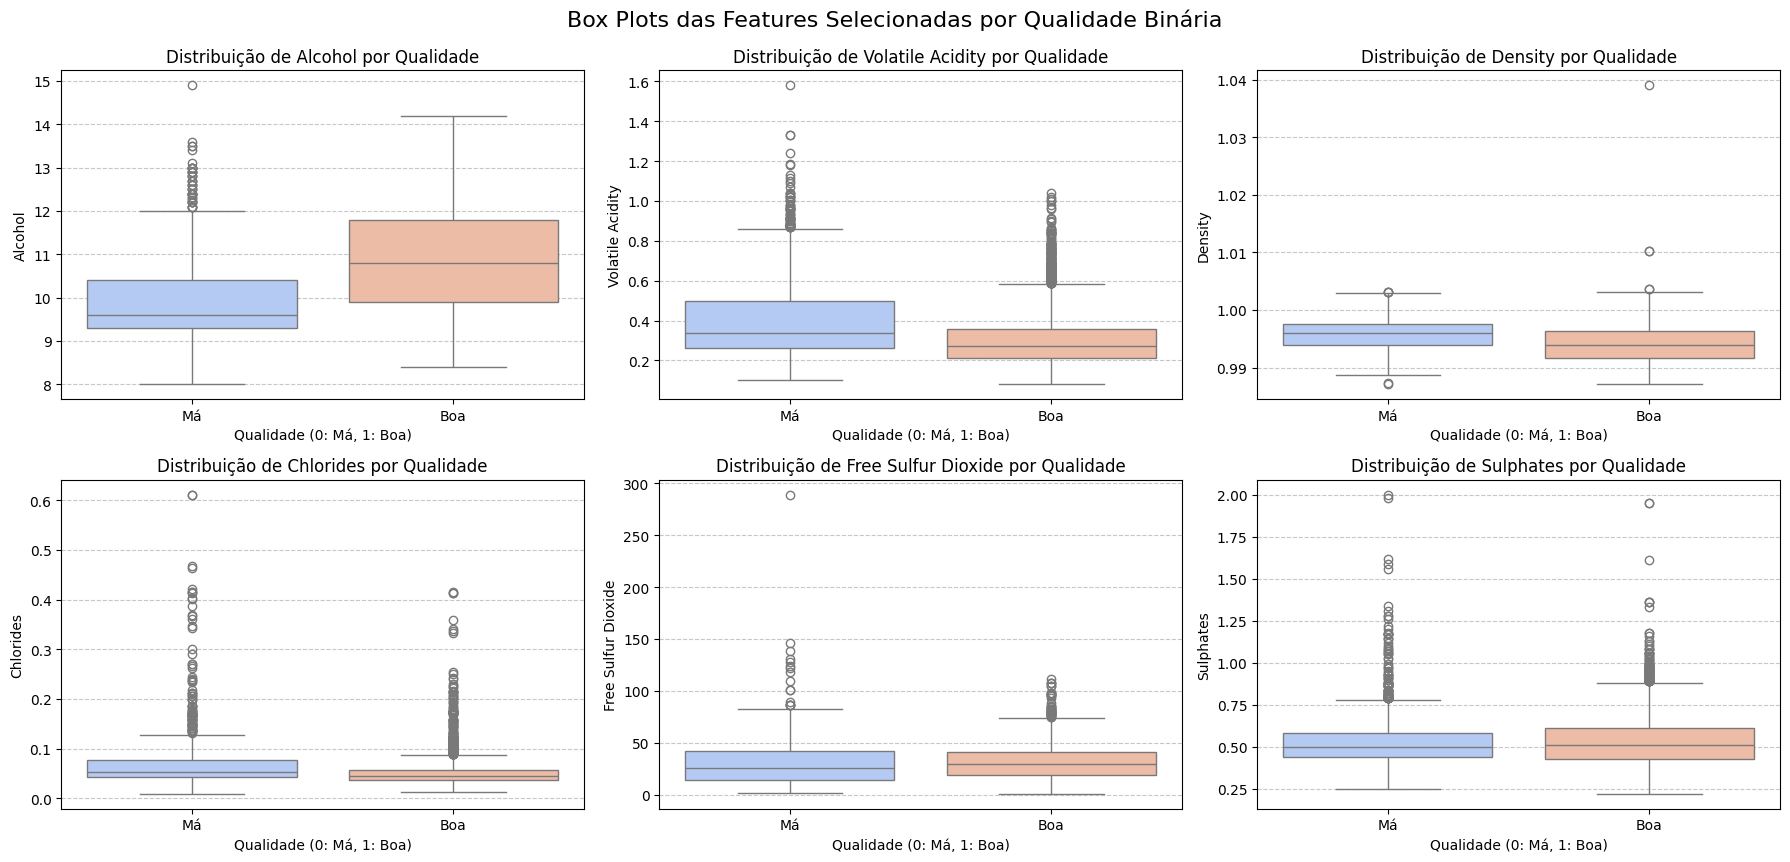

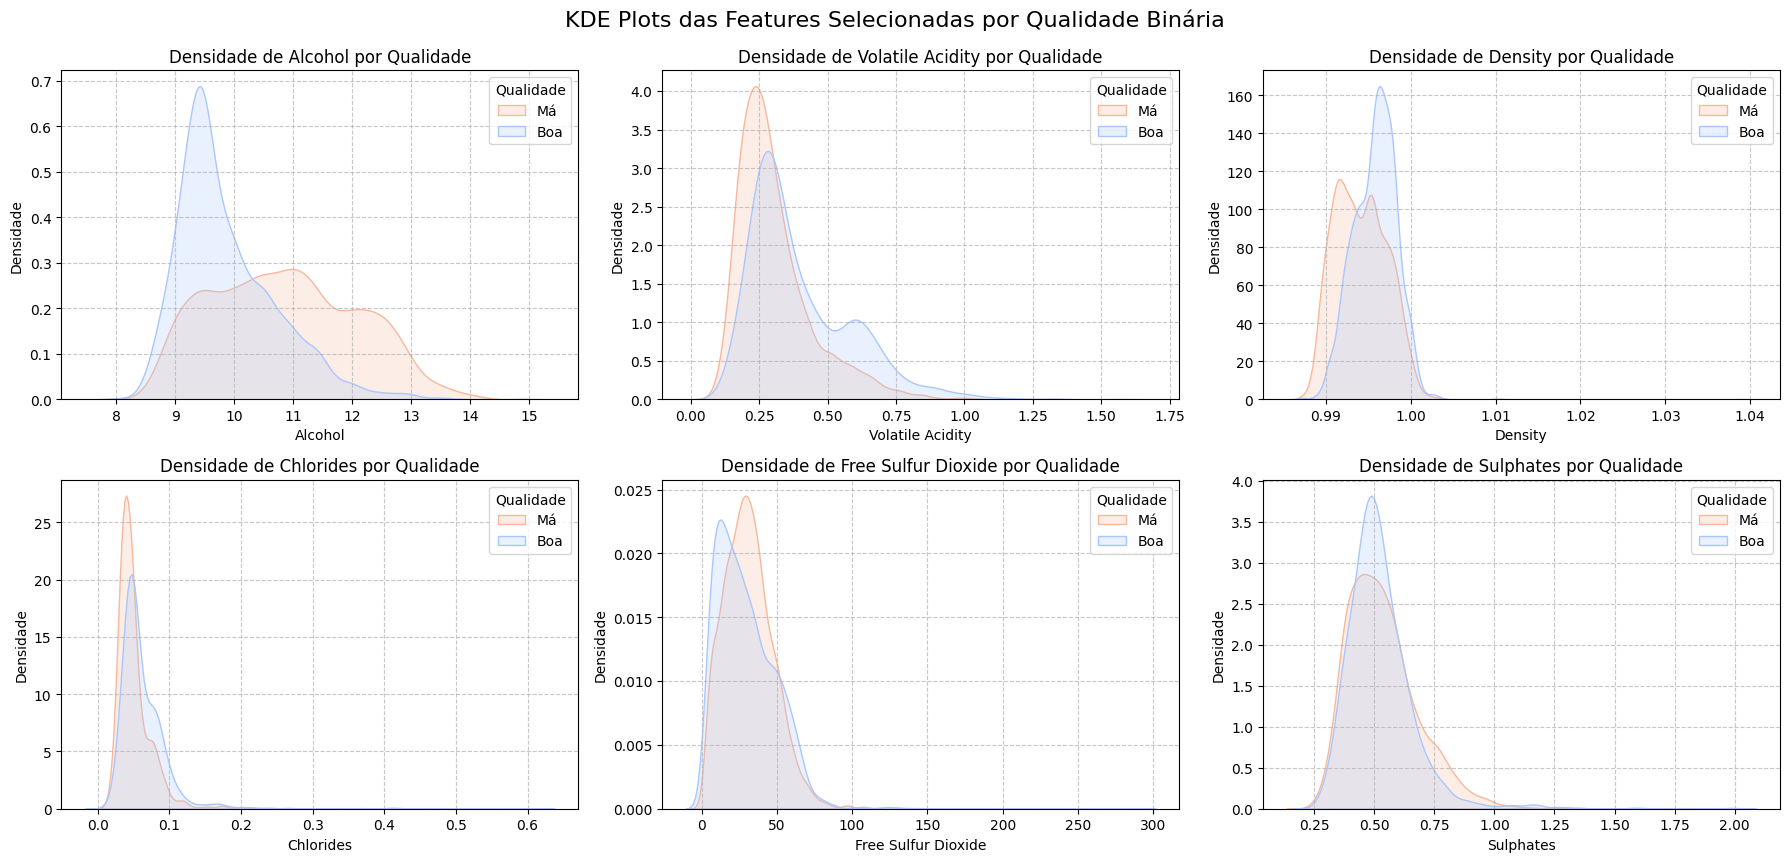

In [4]:
# --- 4.1 Seleção das Features para Box Plots ---
# Com base na matriz de correlação, selecionamos as features que geralmente são mais importantes.
# Ordem baseada na sua análise anterior e correlações mais altas.
top_eda_features = [
    'alcohol',
    'volatile acidity',
    'density',
    'chlorides',
    'free sulfur dioxide',
    'sulphates', # Adicionando sulfatos, pois costuma ser relevante.
]

print(f"\n--- Box Plots das Features Mais Importantes (selecionadas da correlação) ---")

# --- 4.2 Gerar Box Plots ---
plt.figure(figsize=(18, 12))
for i, feature in enumerate(top_eda_features):
    plt.subplot(3, 3, i + 1) # Ajusta o layout conforme o número de features. Max 9 plots aqui.
    sns.boxplot(x='good_quality', y=feature, data=df_wine, palette='coolwarm')
    plt.title(f'Distribuição de {feature.replace("_", " ").title()} por Qualidade')
    plt.xlabel('Qualidade (0: Má, 1: Boa)')
    plt.ylabel(feature.replace("_", " ").title())
    plt.xticks(ticks=[0, 1], labels=['Má', 'Boa'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.suptitle('Box Plots das Features Selecionadas por Qualidade Binária', y=1.02, fontsize=16)
plt.show()

# --- Opcional: KDE plots para ver a densidade da distribuição ---
plt.figure(figsize=(18, 12))
for i, feature in enumerate(top_eda_features):
    plt.subplot(3, 3, i + 1)
    sns.kdeplot(data=df_wine, x=feature, hue='good_quality', fill=True, common_norm=False, palette='coolwarm')
    plt.title(f'Densidade de {feature.replace("_", " ").title()} por Qualidade')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Densidade')
    plt.legend(title='Qualidade', labels=['Má', 'Boa'])
    plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle('KDE Plots das Features Selecionadas por Qualidade Binária', y=1.02, fontsize=16)
plt.show()